In [1]:
import os
import pathlib
import time
import datetime
from IPython import display
import tensorflow as tf
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
sample_image = tf.io.read_file("../input/sketch2face/sketch2face/train/10.jpg")
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

2022-04-11 17:36:24.917574: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 17:36:25.002052: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 17:36:25.002760: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 17:36:25.005956: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

(256, 512, 3)


2022-04-11 17:36:25.007562: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 17:36:25.008333: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 17:36:25.009095: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 17:36:26.803532: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 17:36:26.804474: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

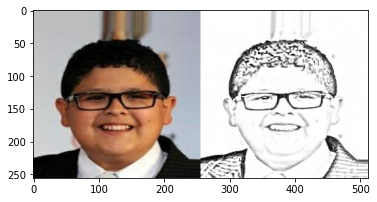

In [3]:
plt.imshow(sample_image)
plt.show()

In [4]:
def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)

    w = tf.shape(image)[1]
    w = w // 2 

    input_image = image[:, w:, :]
    real_image = image[:, :w, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

In [5]:
def resize(input_image, real_image,h,w):
    input_image = tf.image.resize(input_image,(h,w),method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image,(h,w),method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

In [6]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, 256, 256, 3])

    return cropped_image[0], cropped_image[1]

In [7]:
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [8]:
def random_jitter(input_image, real_image):
    # Resizing to 286x286
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # Random cropping back to 256x256
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
    # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

In [9]:
def load_image_train(image_file):
    input_image, real_image = load_image(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [10]:
def load_image_test(image_file):
    input_image, real_image = load_image(image_file)
    input_image, real_image = resize(input_image, real_image,256,256)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [11]:
train_dataset = tf.data.Dataset.list_files("../input/sketch2face/sketch2face/train/*")
train_dataset = train_dataset.map(load_image_train,num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(400)
train_dataset = train_dataset.batch(1)

In [12]:
test_dataset = tf.data.Dataset.list_files("../input/sketch2face/sketch2face/test/*")
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

In [13]:
def encode(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters, size, padding='same',kernel_initializer=initializer, use_bias=False))
    model.add(tf.keras.layers.MaxPool2D())
    if apply_batchnorm:
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    return model

In [14]:
def decode(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2DTranspose(filters, size,padding='same',kernel_initializer=initializer,use_bias=False))
    model.add(tf.keras.layers.UpSampling2D())
    model.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
      model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.ReLU())

    return model

In [15]:
def Generator():
    inputs = tf.keras.layers.Input(shape=(256,256,3))

    down_stack = [
    encode(64, 4, apply_batchnorm=False),
    encode(128, 4),
    encode(256, 4),
    encode(512, 4),
    encode(512, 4),
    encode(512, 4),
    encode(512, 4),
    encode(512, 4)]

    up_stack = [
    decode(512, 4, apply_dropout=True),
    decode(512, 4, apply_dropout=True),
    decode(512, 4, apply_dropout=True),
    decode(512, 4),
    decode(256, 4),
    decode(128, 4),
    decode(64, 4)]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4,strides=2,padding='same',kernel_initializer=initializer,activation='tanh')

    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

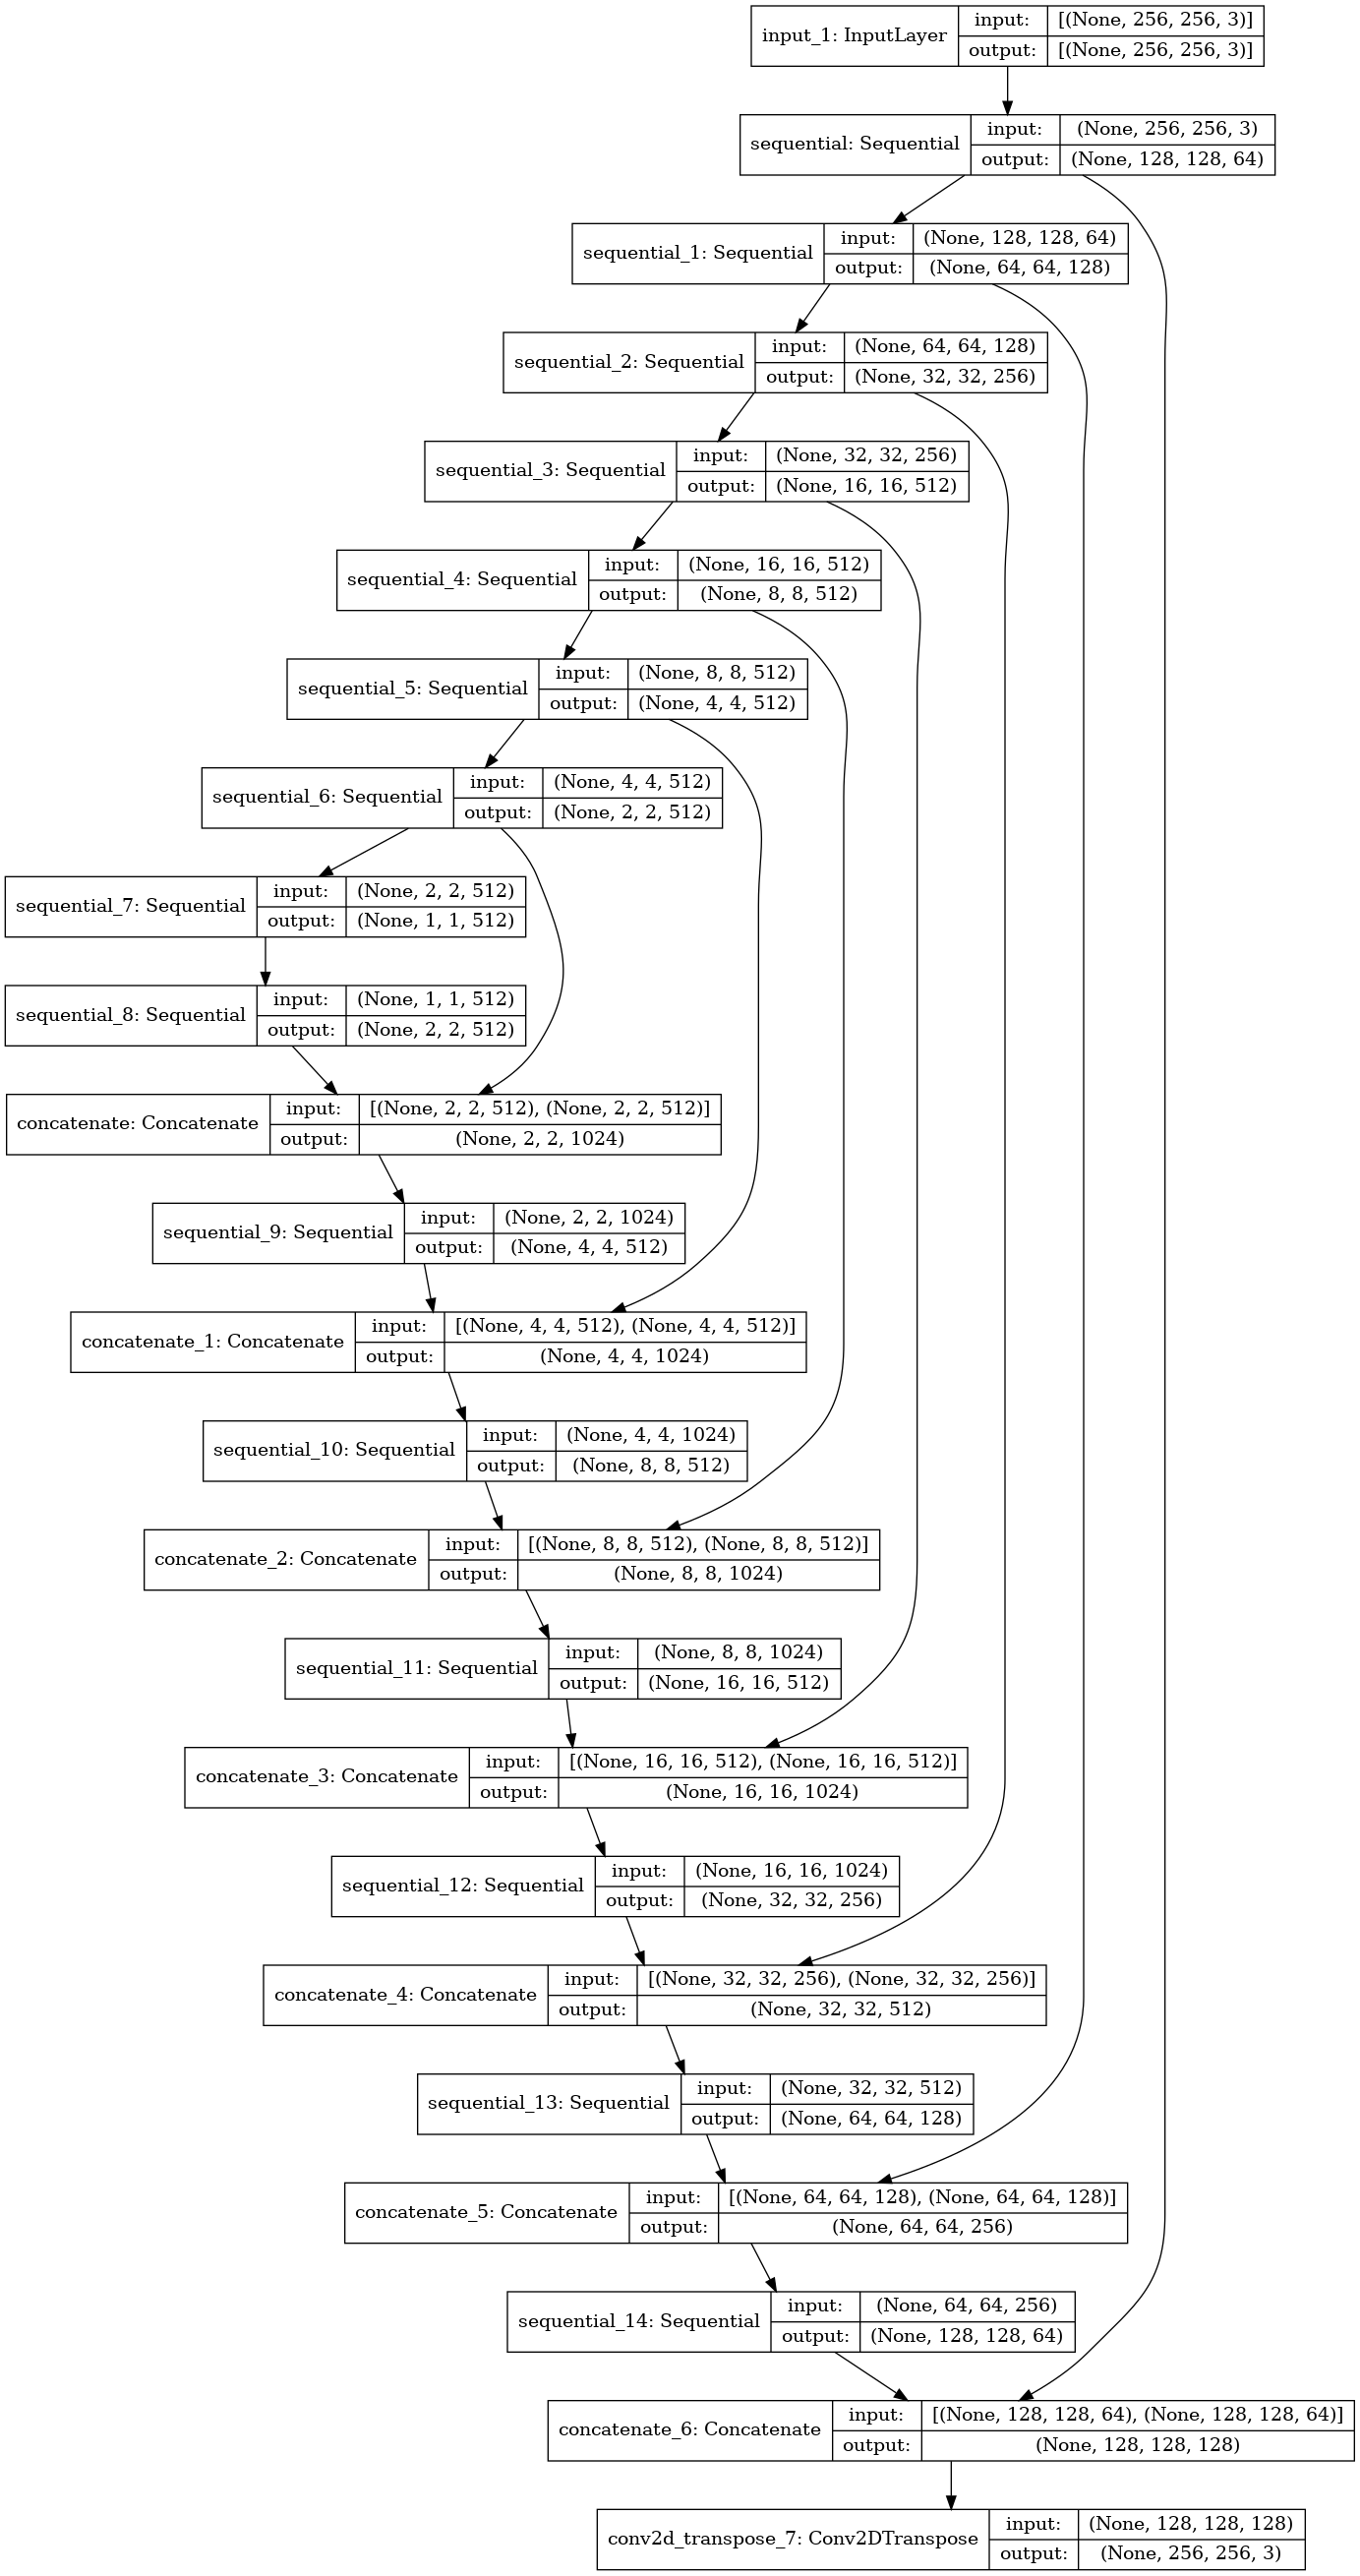

In [16]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True)

In [17]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
def generator_loss(real, fake, target):
    gan_loss = loss_function(tf.ones_like(real), real)
    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - fake))
    total_gen_loss = gan_loss + (100 * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [19]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    input_image = tf.keras.layers.Input(shape=(256,256,3), name='input_image')
    target_image = tf.keras.layers.Input(shape=(256,256,3), name='target_image')
    x = tf.keras.layers.concatenate([input_image, target_image])

    encode1 = encode(64, 4, False)(x)
    encode2 = encode(128, 4)(encode1)
    encode3 = encode(256, 4)(encode2)
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(encode3)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,kernel_initializer=initializer,use_bias=False)(zero_pad1)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    last = tf.keras.layers.Conv2D(1, 4, strides=1,kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=[input_image, target_image], outputs=last)

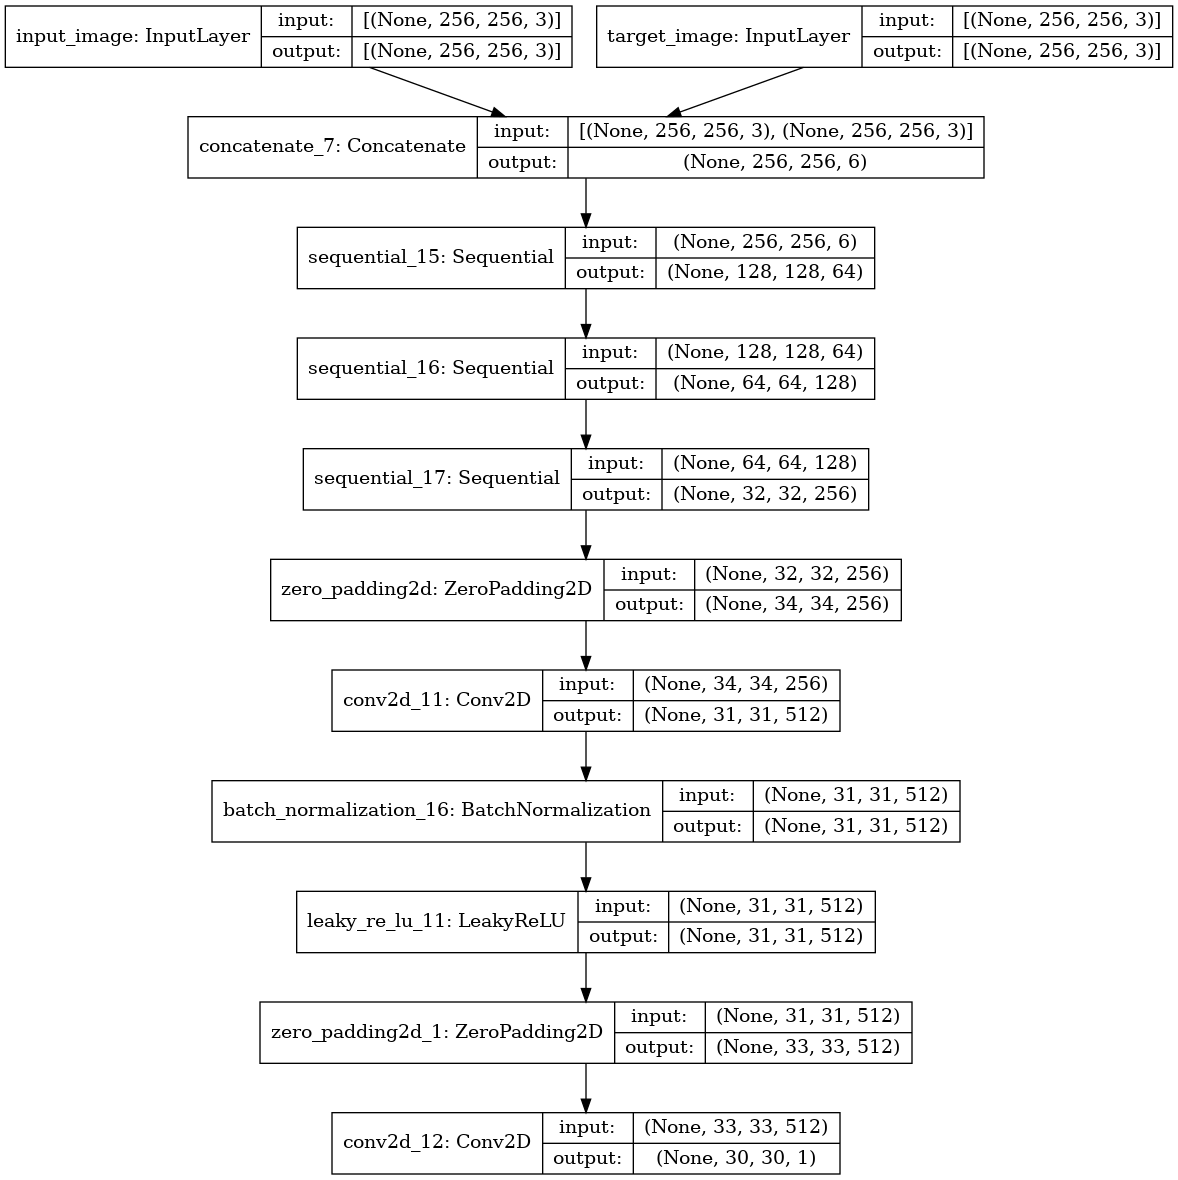

In [20]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True)

In [21]:
def discriminator_loss(real, fake):
    real_loss = loss_function(tf.ones_like(real),real)
    generated_loss = loss_function(tf.zeros_like(fake), fake)
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [22]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [23]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [24]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [25]:
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [26]:
def fit(train, test, steps):
  example_input, example_target = next(iter(test.take(1)))
  start = time.time()

  for step, (input_image, target) in train.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)

Time taken for 1000 steps: 155.75 sec



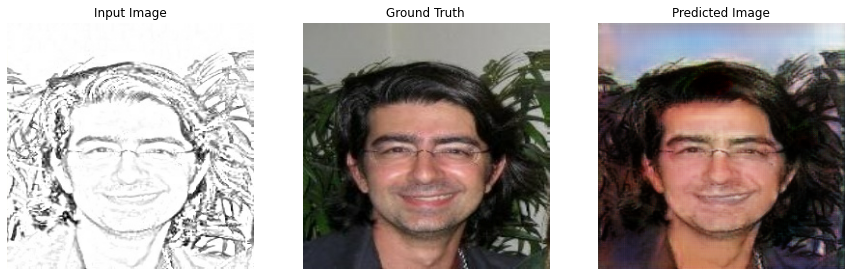

Step: 39k
....................................................................................................

In [27]:
fit(train_dataset, test_dataset, steps=40000)

In [29]:
generator.save("sketch.h5")